AirPassengers data set contains Monthly Airline Passenger Numbers (in thousands) for 1949-1960 years.<br>
The main goal of this project, is to:
1. Check if it is stationarity and if not transfor to stationary
2. Find the best time series model to predict the sound pressure level.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Grouper
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
air_passengers = pd.read_csv("AirPassengers.csv", parse_dates=['Month'], index_col='Month')

In [3]:
air_passengers

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [4]:
air_passengers.rename({'#Passengers': 'Passengers'}, inplace=True, axis='columns')

In [5]:
air_passengers.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Let's check how this data looks.

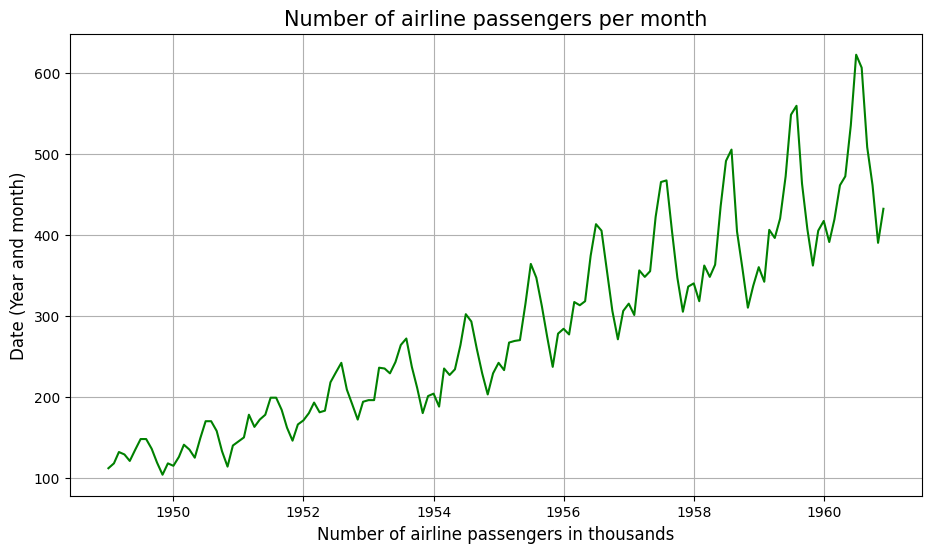

In [6]:
plt.figure(figsize=(11,6), dpi=100)
plt.plot(air_passengers.index, air_passengers['Passengers'], color='green')
plt.title('Number of airline passengers per month', fontsize=15)
plt.xlabel("Number of airline passengers in thousands", fontsize=12)
plt.ylabel("Date (Year and month)", fontsize=12)
plt.grid()
plt.show()

We can see that trend is upwards and we have seasonal pattern.<br>
Let's check trend and seasonality even more deeply.

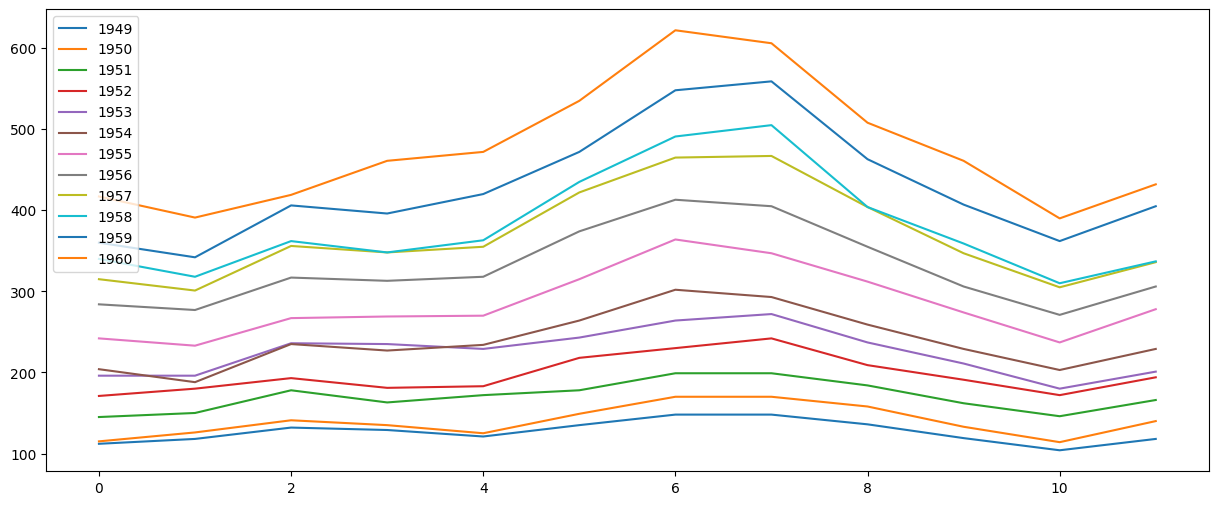

In [7]:
air_passengers_series = air_passengers.Passengers
groups = air_passengers_series.groupby(Grouper(freq = 'Y'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(figsize=(15,6))
plt.show()

In [8]:
air_passengers['Year'] = [item.year for item in air_passengers.index]
air_passengers['Month'] = [item.strftime('%b') for item in air_passengers.index]
air_passengers

,Passengers,Year,Month
Month,,,
1949-01-01,112,1949,Jan
1949-02-01,118,1949,Feb
1949-03-01,132,1949,Mar
1949-04-01,129,1949,Apr
1949-05-01,121,1949,May
...,...,...,...
1960-08-01,606,1960,Aug
1960-09-01,508,1960,Sep
1960-10-01,461,1960,Oct


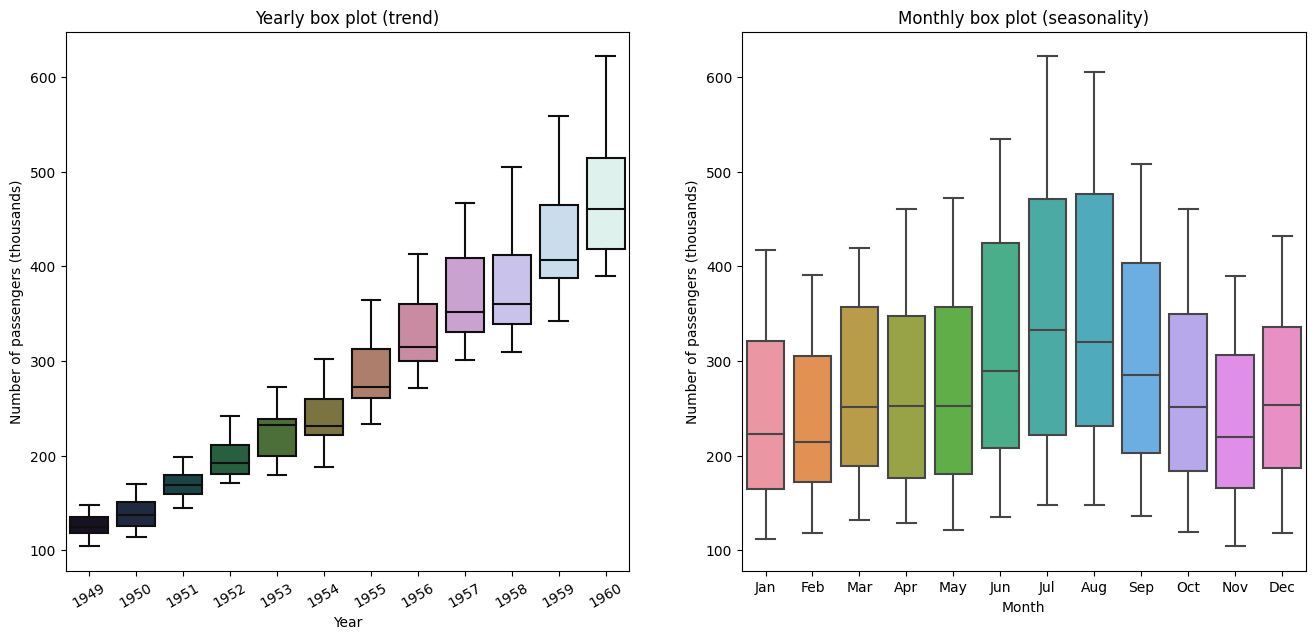

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.boxplot(x='Year', y='Passengers', data=air_passengers, ax=axes[0], palette='cubehelix').set(
    xlabel='Year',
    ylabel='Number of passengers (thousands)')

sns.boxplot(x='Month', y='Passengers', data=air_passengers, ax=axes[1]).set(
    xlabel='Month',
    ylabel='Number of passengers (thousands)')

axes[0].set_title('Yearly box plot (trend)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)
axes[1].set_title('Monthly box plot (seasonality)')
plt.show()

Now it is more clear that trend is upwards and there is seasonal pattern.<br>
We can say that this Time Series is non-stationary but let's check it more closely.

In [10]:
def check_time_series_stationary(y, rolling_len = 12):
    y = pd.Series(y)
    df_test = adfuller(y)
    if df_test[1] < 0.05:
        print('Time series is stationary')
    else:
        print('Time series is non-stationary')
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()
    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

Time series is non-stationary
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     0.8154
p-value             :     0.9919
--------------------------------



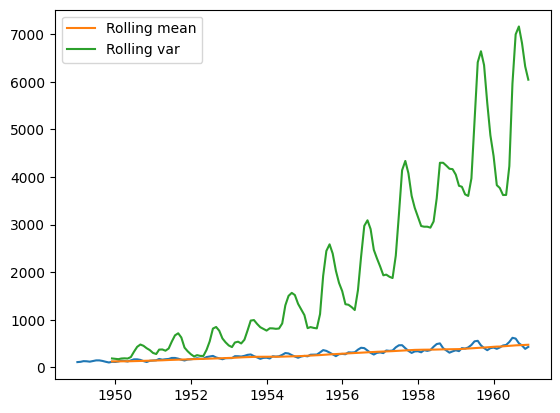

      Autocorrelation plot      
--------------------------------



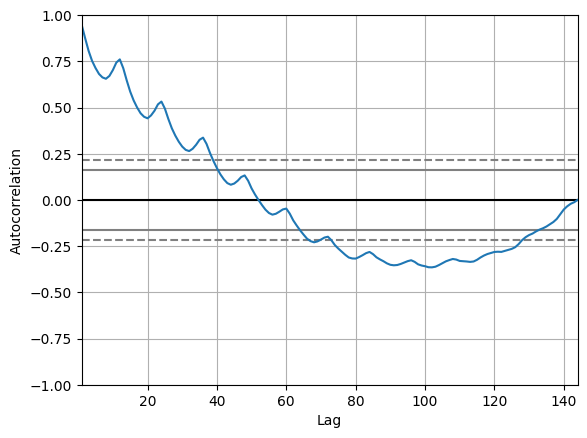

In [11]:
check_time_series_stationary(air_passengers.Passengers)

These three metrics clearly show that this Time Series data is non-stationary. <br>
Now let's try to transfer this data to stationary to make predictions.

1. We can stabilize wariance (green line) by logarithm.

In [12]:
air_passengers_log = np.log(air_passengers.Passengers)

Time series is non-stationary
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -1.7170
p-value             :     0.4224
--------------------------------



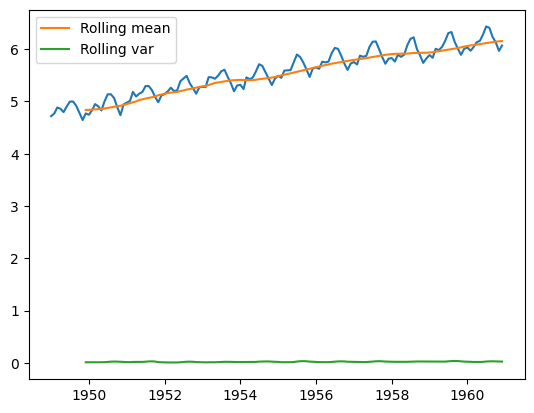

      Autocorrelation plot      
--------------------------------



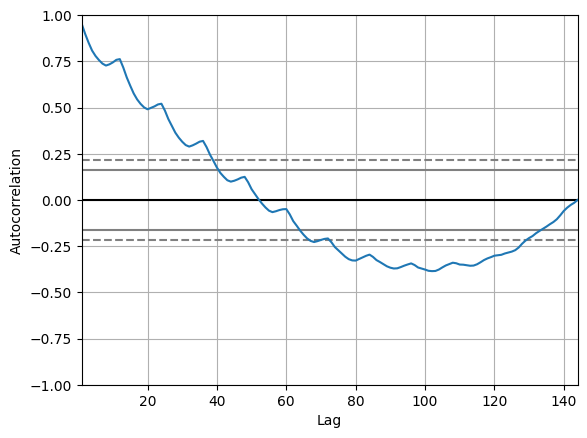

In [13]:
check_time_series_stationary(air_passengers_log)

2. Now, let's delete trend.

In [15]:
air_passengers_log_diff = air_passengers_log.diff(1).dropna()

Time series is non-stationary
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.7171
p-value             :     0.0711
--------------------------------



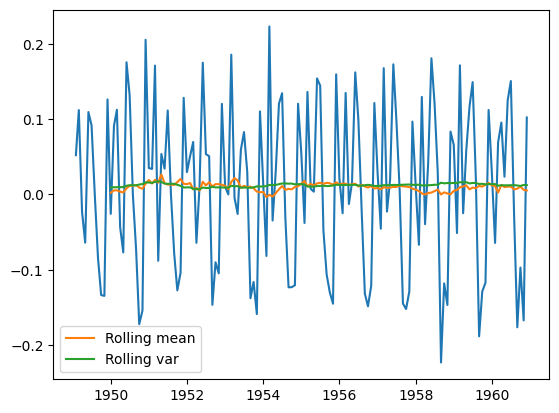

      Autocorrelation plot      
--------------------------------



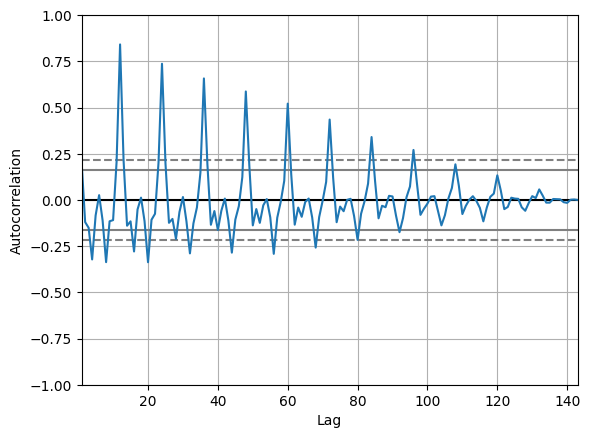

In [16]:
check_time_series_stationary(air_passengers_log_diff)

3. Finaly let's delete seasonality.

In [17]:
air_passengers_log_diff_12 = air_passengers_log_diff.diff(12).dropna()

Time series is stationary
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.4433
p-value             :     0.0002
--------------------------------



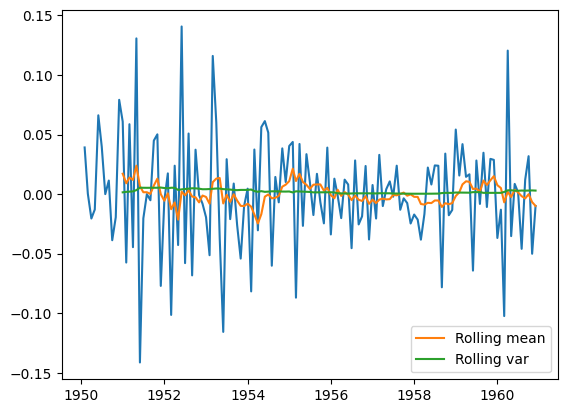

      Autocorrelation plot      
--------------------------------



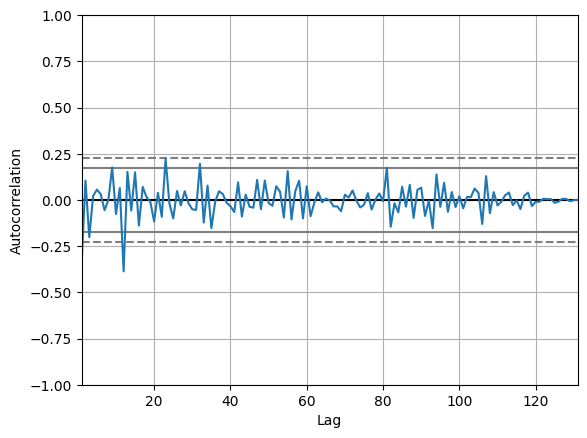

In [18]:
check_time_series_stationary(air_passengers_log_diff_12)

Modeling

/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


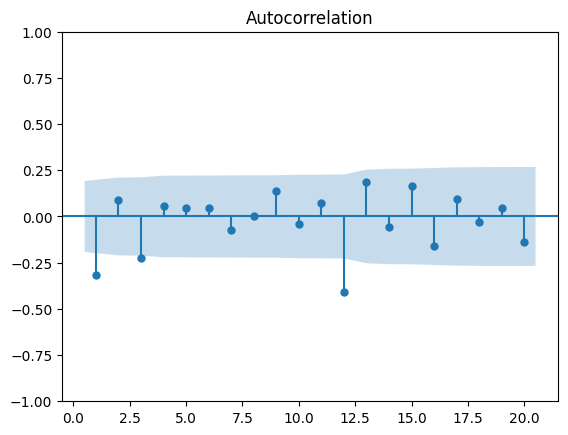

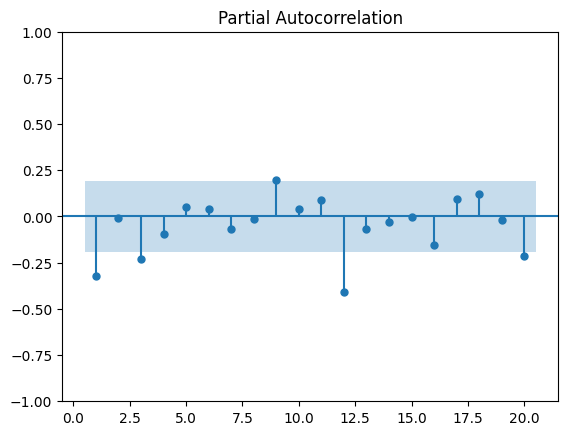

In [20]:
k = int(air_passengers_log_diff_12.size * 0.8)

air_passengers_log_diff_12_train = air_passengers_log_diff_12[:k]
air_passengers_log_diff_12_test = air_passengers_log_diff_12[k:]

plot_acf(air_passengers_log_diff_12_train ,lags = 20,zero = False)
plot_pacf(air_passengers_log_diff_12_train ,lags = 20,zero = False)
plt.show()

It looks like the best will be AR-3 and MA-3.

In [46]:
n = int(air_passengers.Passengers.size * 0.8)

air_passengers_train = air_passengers[:n]
air_passengers_test = air_passengers[n:]

model = SARIMAX(endog=air_passengers_train.Passengers, order=(3, 1, 3),seasonal_order = (0,1,0,12), trend='c').fit()

/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23728D+00    |proj g|=  1.15699D-02

At iterate    5    f=  3.23434D+00    |proj g|=  9.55281D-03

At iterate   10    f=  3.22762D+00    |proj g|=  2.64576D-02

At iterate   15    f=  3.22302D+00    |proj g|=  1.92817D-02

At iterate   20    f=  3.21982D+00    |proj g|=  6.10142D-03

At iterate   25    f=  3.21941D+00    |proj g|=  4.45656D-03

At iterate   30    f=  3.21861D+00    |proj g|=  5.37239D-03

At iterate   35    f=  3.21805D+00    |proj g|=  1.31375D-02

At iterate   40    f=  3.21784D+00    |proj g|=  3.56223D-03

At iterate   45    f=  3.21775D+00    |proj g|=  2.11643D-03

At iterate   50    f=  3.21772D+00    |proj g|=  3.14930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


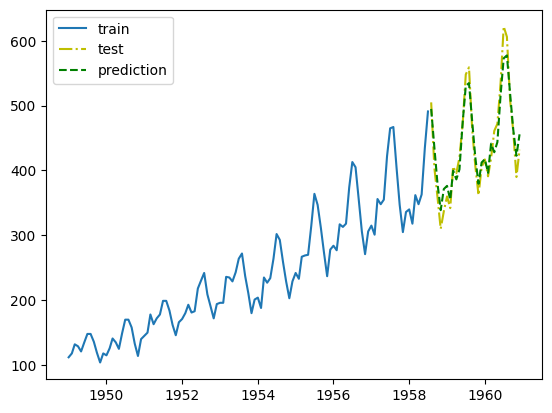

In [51]:
model_pred = model.predict(start='1958-08-01', end='1960-12-01', dynamic=True)

plt.plot(air_passengers_train.Passengers, label="train")
plt.plot(air_passengers_test.Passengers,'y-.', label="test")
plt.plot(model_pred, 'g--', label="prediction")
plt.legend()
plt.show()